# Practical: Atomate 2

This is a practical session on using atomate 2 to run some calculations using the MACE potential that we used last time.

You can find more details about atomate 2 at: https://materialsproject.github.io/atomate2/index.html

In [ ]:
!pip install atomate2 mace-torch phonopy seekpath

In atomate 2, there are jobs and workflows. A job is a single calculation, while a workflow is a series of jobs. The workflow is a directed acyclic graph (DAG) where the nodes are jobs and the edges are the dependencies between the jobs. The workflow is defined by a set of rules that determine how the jobs are connected.

## Job: Relaxation using MACE
In this example, we will use atomate 2 to call ASE to run MACE relaxation on a single structure. We will use the `ForceFieldRelaxMaker` class to define the job. The `ForceFieldStaticMaker` class is a subclass of `Job` and it only compute energy and forces statically. To run MACE calculation, you need to set `force_field_name` to `MACE`.



In [85]:
from atomate2.forcefields.jobs import ForceFieldRelaxMaker, ForceFieldStaticMaker

    
mace_relax_maker = ForceFieldRelaxMaker(force_field_name='MACE',
                                  calculator_kwargs={'model': 'medium',
                                                     'default_dtype': 'float64',
                                                     'device': 'cpu'},
                                  relax_cell=True,
                                  ionic_step_data=['energy', 'forces', 'stress'],
                                  store_trajectory=True)

mace_static_maker = ForceFieldStaticMaker(force_field_name='MACE',
                                    calculator_kwargs={'model': 'medium',
                                                     'default_dtype': 'float64',
                                                     'device': 'cpu'},)



### Running a Job Locally

We can use atomate 2 to control our job submission. Here we will use `run_locally()` to run a workflow on our local machine. Before running the workflow, we need to call `make()` to generate a job.



In [ ]:
from jobflow import run_locally
from pymatgen.core import Lattice, Structure

lattice_si = Lattice.from_parameters(a=5.5, b=5.5, c=5.5, alpha=90, beta=90, gamma=90) 

silicon_structure = Structure.from_spacegroup(sg=227, species=["Si"], 
                                              lattice=lattice_si, 
                                              coords=[[0, 0, 0]])

relax_job = mace_relax_maker.make(silicon_structure)

results = run_locally(flow=relax_job, log=False)


2025-03-26 11:42:50,048 INFO Started executing jobs locally


INFO:jobflow.managers.local:Started executing jobs locally


2025-03-26 11:42:50,050 INFO Starting job - Force field relax (d44c94fb-e613-4817-8e66-9d0822419ea9)


INFO:jobflow.core.job:Starting job - Force field relax (d44c94fb-e613-4817-8e66-9d0822419ea9)


Using Materials Project MACE for MACECalculator with /Users/zeyudeng/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/Users/zeyudeng/app/venv/matsci/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/Users/zeyudeng/app/venv/matsci/lib/python3.12/site-packages/atomate2/ase/utils.py:368: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(self.calculator)


2025-03-26 11:42:51,427 INFO Finished job - Force field relax (d44c94fb-e613-4817-8e66-9d0822419ea9)


INFO:jobflow.core.job:Finished job - Force field relax (d44c94fb-e613-4817-8e66-9d0822419ea9)


2025-03-26 11:42:51,428 INFO Finished executing jobs locally


INFO:jobflow.managers.local:Finished executing jobs locally


After running the job, we can check the can be fetched from database.

In [119]:
from jobflow import SETTINGS

store = SETTINGS.JOB_STORE
store.connect()

result = store.query_one(
    properties=[
        "output"
    ],
    load=True,
    sort={"completed_at": -1} # to get the latest computation
)

relaxed_structure = Structure.from_dict(result['output']['structure'])

print(relaxed_structure)



Full Formula (Si8)
Reduced Formula: Si
abc   :   5.471311   5.471313   5.471346
angles:  90.003405  89.999856  89.988317
pbc   :       True       True       True
Sites (8)
  #  SP           a          b          c
---  ----  --------  ---------  ---------
  0  Si    0.499471  -0.000808   0.500059
  1  Si    0.249633   0.249807   0.250375
  2  Si    1.00033    1.0003     0.000729
  3  Si    0.250731   0.750412   0.750823
  4  Si    0.750244   0.250064   0.750427
  5  Si    0.000213   0.499593   0.500589
  6  Si    0.500685   0.500534  -3.1e-05
  7  Si    0.749771   0.749336   0.250843


### Other Workflows
Let's have a look at other more complicated workflows that are available in atomate 2. You can show the provenance of the workflow as graph.

#### Phonon Calculations
Phonon is computed using the finite-displacement method by displacing atoms in the unit cell and calculating the forces on the atoms. Before the finite-displacement method, the structure is relaxed and the forces are calculated. The workflow is as follows:

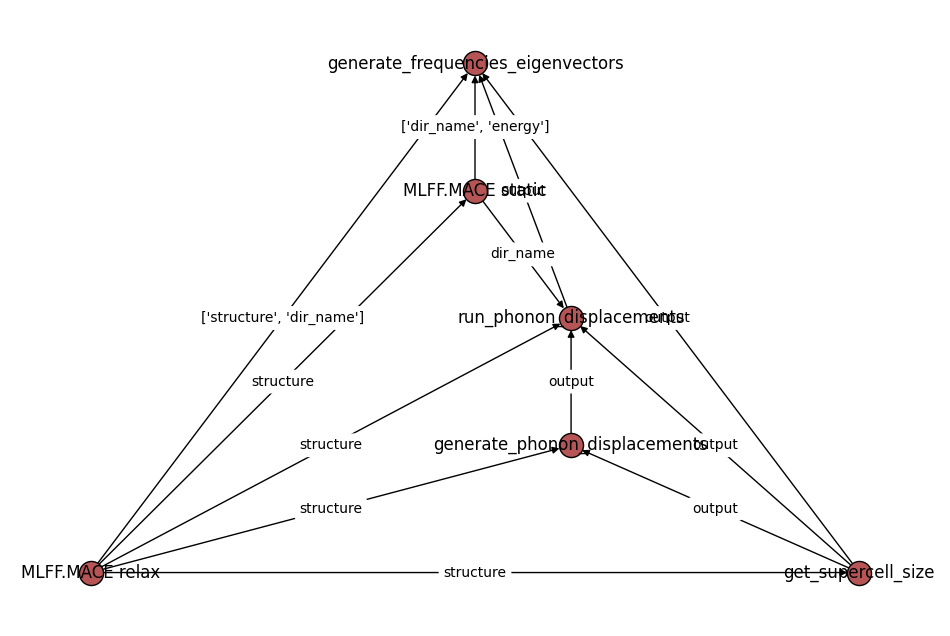

In [ ]:
from atomate2.forcefields.flows.phonons import PhononMaker

lattice_si = Lattice.from_parameters(a=5.43, b=5.43, c=5.43, alpha=90, beta=90, gamma=90) 

silicon_structure = Structure.from_spacegroup(sg=227, species=["Si"], 
                                              lattice=lattice_si, 
                                              coords=[[0, 0, 0]])

phonon_flow = PhononMaker(min_length=15.0, store_force_constants=False, 
                          bulk_relax_maker=mace_relax_maker, 
                          static_energy_maker= mace_static_maker,
                          phonon_displacement_maker= mace_static_maker,
                          born_maker=None,
                          kpath_scheme='seekpath').make(structure=silicon_structure)


phonon_flow.draw_graph().show()


In [9]:
run_locally(flow=phonon_flow, log=False)

Using Materials Project MACE for MACECalculator with /Users/zeyudeng/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/Users/zeyudeng/app/venv/matsci/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/Users/zeyudeng/app/venv/matsci/lib/python3.12/site-packages/atomate2/ase/utils.py:368: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(self.calculator)


Using Materials Project MACE for MACECalculator with /Users/zeyudeng/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/Users/zeyudeng/app/venv/matsci/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/Users/zeyudeng/app/venv/matsci/lib/python3.12/site-packages/atomate2/ase/utils.py:368: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(self.calculator)
/Users/zeyudeng/app/venv/matsci/lib/python3.12/site-packages/jobflow/core/job.py:604: UserWarning: Initial magnetic moments will not be considered for the determination of the symmetry of the structure and thus will be removed now.
  response = function(*self.function_args, **self.function_kwargs)
<string>:16: FutureWarning: MACEStaticMaker is deprecated, and will be removed on 2025-01-01
Use ForceFieldStaticMaker in atomate2.forcefields.jobs instead.
To use MACE, set `force_field_name = 'MACE'` in Forc

Using Materials Project MACE for MACECalculator with /Users/zeyudeng/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/Users/zeyudeng/app/venv/matsci/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_lattice']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/zeyudeng/app/venv/matsci/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_positions']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/zeyudeng/app/venv/matsci/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_types']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/zeyudeng/app/venv/matsci/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/zeyudeng/app/v

{'aa5854fa-faa2-4dd5-aa05-795473e91ae8': {1: Response(output=ForceFieldTaskDocument(builder_meta=EmmetMeta(emmet_version='0.84.6rc3', pymatgen_version='2025.1.24', run_id=None, batch_id=None, database_version=None, build_date=datetime.datetime(2025, 3, 26, 3, 10, 14, 932776, tzinfo=datetime.timezone.utc), license=None), nsites=None, elements=None, nelements=None, composition=None, composition_reduced=None, formula_pretty=None, formula_anonymous=None, chemsys=None, volume=None, density=None, density_atomic=None, symmetry=None, structure=Structure Summary
  Lattice
      abc : 5.4387539954606146 5.438753995460613 5.438753995460613
   angles : 89.99999999999997 90.0 90.0
   volume : 160.8785880555009
        A : 5.4387539954606146 2.0573017782952598e-17 3.0535037342042895e-16
        B : -3.0324931565082235e-16 5.438753995460613 1.5713706579056844e-15
        C : -4.8136061687354604e-17 2.223194470221846e-15 5.438753995460613
      pbc : True True True
  PeriodicSite: Si (2.719, 1.321e-15

In [48]:
from pymatgen.phonon.bandstructure import PhononBandStructureSymmLine
from pymatgen.phonon.dos import PhononDos
from pymatgen.phonon.plotter import PhononBSPlotter, PhononDosPlotter
from jobflow import SETTINGS

store = SETTINGS.JOB_STORE
store.connect()

result = store.query_one(
    {"name": "generate_frequencies_eigenvectors"},
    properties=[
        "output.phonon_dos",
        "output.phonon_bandstructure",
    ],
    load=True,
    sort={"completed_at": -1} # to get the latest computation
)

Then we can visualize the phonon results as below:

<Axes: xlabel='$\\mathrm{Wave\\ Vector}$', ylabel='$\\mathrm{Frequencies\\ (THz)}$'>

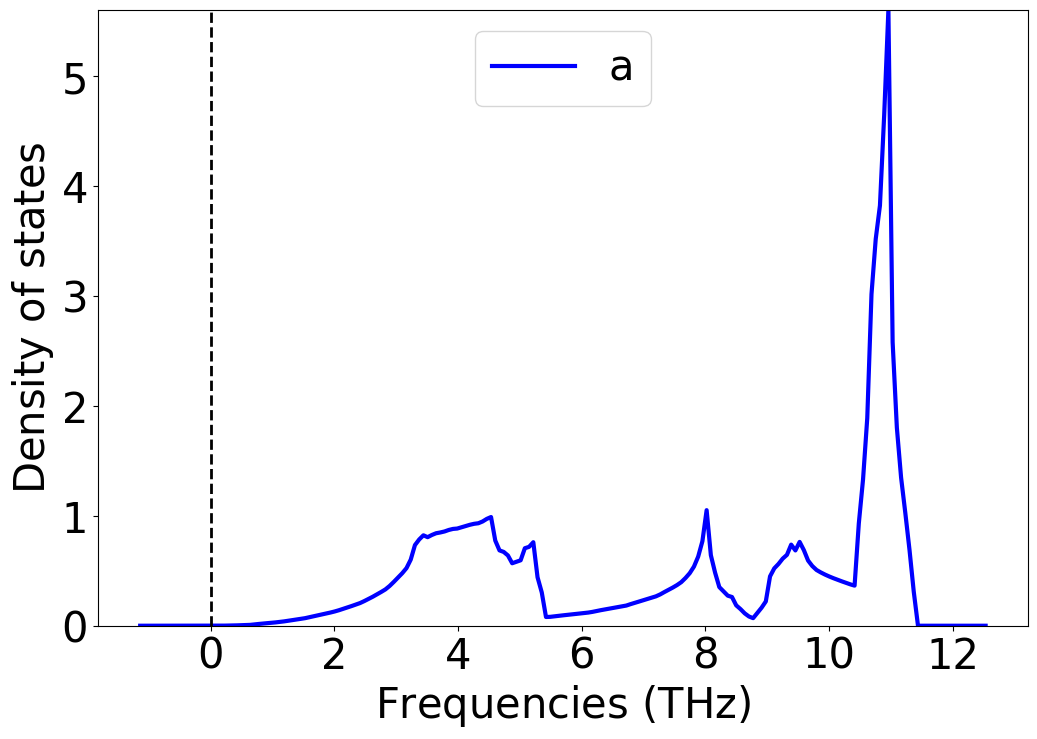

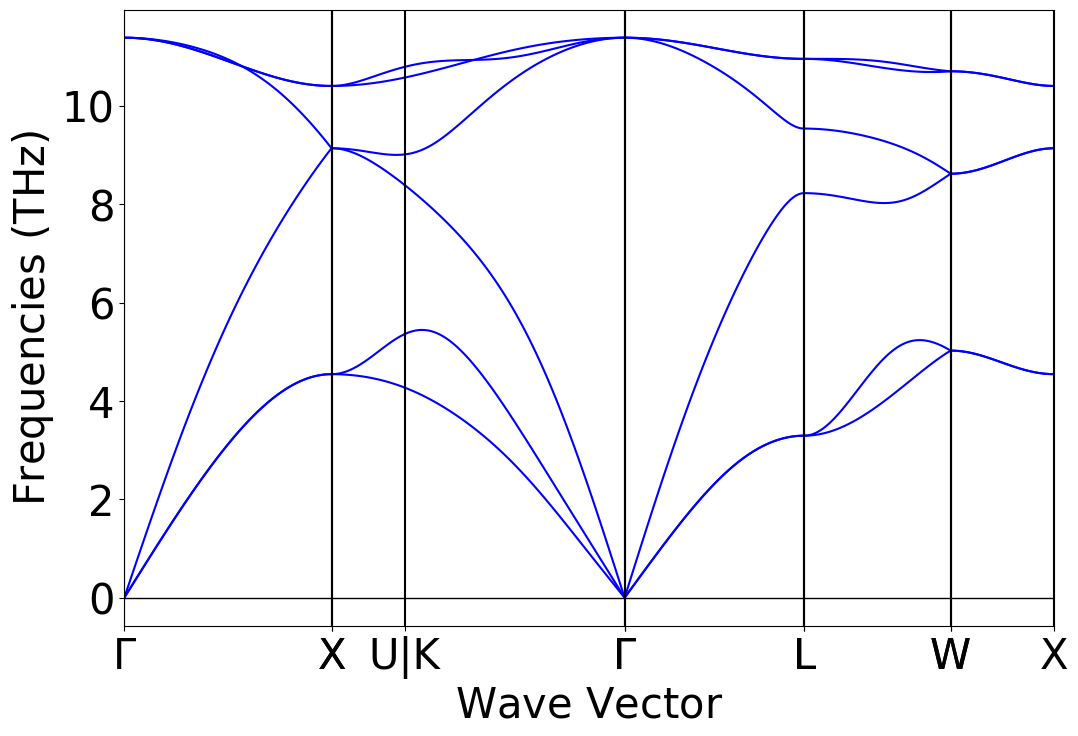

In [46]:
ph_bs = PhononBandStructureSymmLine.from_dict(result['output']['phonon_bandstructure']) # get pymatgen bandstructure object
ph_dos = PhononDos.from_dict(result['output']['phonon_dos']) # get pymatgen phonon dos object

# initialize dos plotter and visualize dos plot
dos_plot = PhononDosPlotter()
dos_plot.add_dos(label='a', dos=ph_dos)
dos_plot.get_plot()

# initialize Phonon bandstructure plotter and visualize band structure plot
bs_plot = PhononBSPlotter(bs=ph_bs)
bs_plot.get_plot()

You can also setup the phonon workflow calculation for DFT calculation using VASP. Just import the `PhononMaker` from the `atomate2.vasp.flows.phonon` module. Since VASP needs to be run on a HPC, we will not run this workflow here.

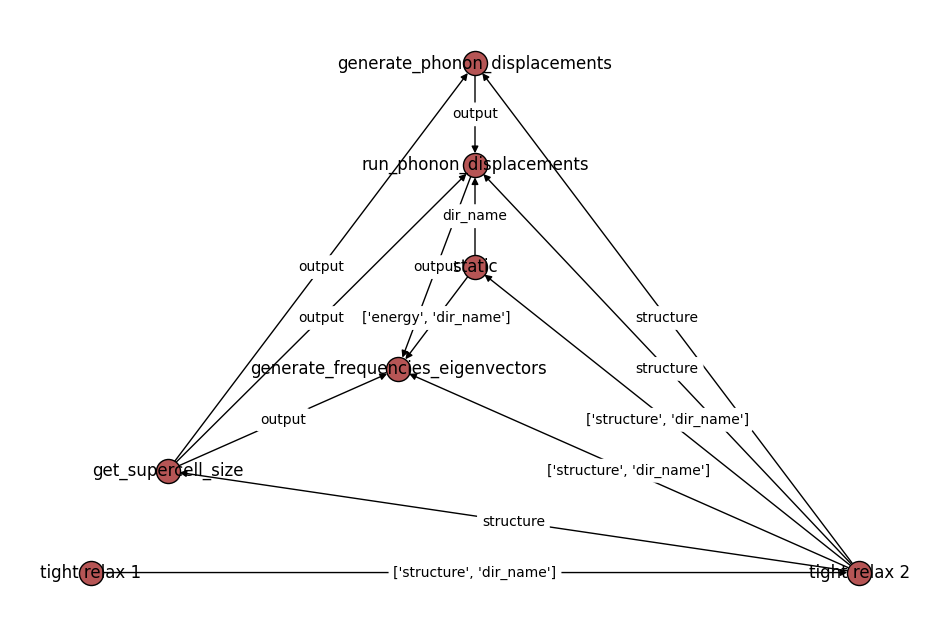

In [83]:
from atomate2.vasp.flows.phonons import PhononMaker
phonon_flow = PhononMaker(born_maker=None).make(structure=silicon_structure)

phonon_flow.draw_graph().show()


#### Elastic Constants
The elastic constants are calculated by applying strains to the unit cell and calculating the stress on the atoms. Below is a workflow for calculating the elastic constants using force field.

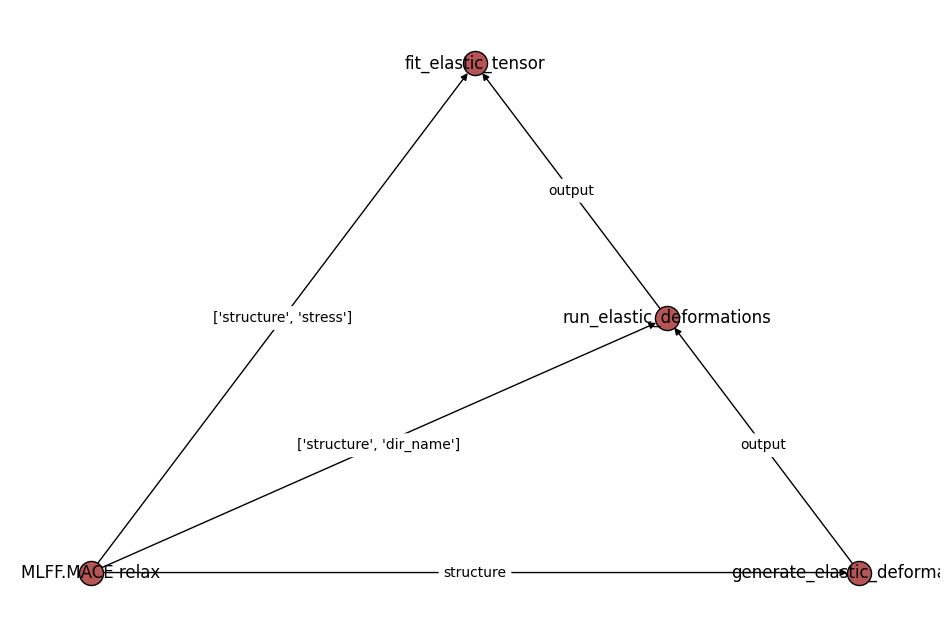

In [16]:
from atomate2.forcefields.flows.elastic import ElasticMaker

elastic_flow = ElasticMaker(bulk_relax_maker=mace_relax_maker, elastic_relax_maker=mace_relax_maker).make(structure=silicon_structure)

elastic_flow.draw_graph().show()


In [51]:
run_locally(flow=elastic_flow, log=False)

/Users/zeyudeng/app/venv/matsci/lib/python3.12/site-packages/jobflow/core/flow.py:431: UserWarning: Some jobs are not connected, their ordering may be random
  for node in itergraph(graph):
/Users/zeyudeng/app/venv/matsci/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/Users/zeyudeng/app/venv/matsci/lib/python3.12/site-packages/atomate2/ase/utils.py:368: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(self.calculator)


Using Materials Project MACE for MACECalculator with /Users/zeyudeng/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using Materials Project MACE for MACECalculator with /Users/zeyudeng/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/Users/zeyudeng/app/venv/matsci/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/Users/zeyudeng/app/venv/matsci/lib/python3.12/site-packages/atomate2/ase/utils.py:368: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(self.calculator)


Using Materials Project MACE for MACECalculator with /Users/zeyudeng/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/Users/zeyudeng/app/venv/matsci/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/Users/zeyudeng/app/venv/matsci/lib/python3.12/site-packages/atomate2/ase/utils.py:368: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(self.calculator)


Using Materials Project MACE for MACECalculator with /Users/zeyudeng/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using Materials Project MACE for MACECalculator with /Users/zeyudeng/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/Users/zeyudeng/app/venv/matsci/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/Users/zeyudeng/app/venv/matsci/lib/python3.12/site-packages/atomate2/ase/utils.py:368: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(self.calculator)
/Users/zeyudeng/app/venv/matsci/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/Users/zeyudeng/app/venv/matsci/lib/python3.12/site-packages/atomate2/ase/utils.py:368: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(self.calculator)
/Users/zeyudeng/

Using Materials Project MACE for MACECalculator with /Users/zeyudeng/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using Materials Project MACE for MACECalculator with /Users/zeyudeng/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/Users/zeyudeng/app/venv/matsci/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/Users/zeyudeng/app/venv/matsci/lib/python3.12/site-packages/atomate2/ase/utils.py:368: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(self.calculator)


{'e2091181-1652-452e-b138-037ec18b1ef9': {1: Response(output=ForceFieldTaskDocument(builder_meta=EmmetMeta(emmet_version='0.84.6rc3', pymatgen_version='2025.1.24', run_id=None, batch_id=None, database_version=None, build_date=datetime.datetime(2025, 3, 26, 3, 22, 31, 40071, tzinfo=datetime.timezone.utc), license=None), nsites=None, elements=None, nelements=None, composition=None, composition_reduced=None, formula_pretty=None, formula_anonymous=None, chemsys=None, volume=None, density=None, density_atomic=None, symmetry=None, structure=Structure Summary
  Lattice
      abc : 5.4387539954606146 5.438753995460613 5.438753995460613
   angles : 89.99999999999997 90.0 90.0
   volume : 160.8785880555009
        A : 5.4387539954606146 2.0573017782952598e-17 3.0535037342042895e-16
        B : -3.0324931565082235e-16 5.438753995460613 1.5713706579056844e-15
        C : -4.8136061687354604e-17 2.223194470221846e-15 5.438753995460613
      pbc : True True True
  PeriodicSite: Si (2.719, 1.321e-15,

Then we can get the computed elastic constants as below:

In [ ]:
from jobflow import SETTINGS

store = SETTINGS.JOB_STORE
store.connect()

result = store.query_one(
    # {"name": "generate_elastic_tensor"},
    properties=[
        "output",
    ],
    sort={"completed_at": -1} # to get the latest computation
)

print(result['output']['elastic_tensor']['raw'])

[[48.16791628275555, 7.000664372088321, 7.000664372068957, -3.617474078706534e-15, -2.7428399994911246e-15, -8.034786361681128e-15], [7.000664372088321, 48.16791628275562, 7.00066437207866, 1.6803013347139928e-14, -4.366847215756815e-15, -5.535407355640349e-15], [7.000664372068957, 7.00066437207866, 48.167916282755606, 9.586563687076524e-15, -7.259348380889793e-16, -4.36684721574258e-15], [-3.617474078706534e-15, 1.6803013347139928e-14, 9.586563687076524e-15, 49.18898116200048, 3.3014616048755746e-27, 3.1036047699087127e-27], [-2.7428399994911246e-15, -4.366847215756815e-15, -7.259348380889793e-16, 3.3014616048755746e-27, 49.18898116200045, 1.1310254464451013e-15], [-8.034786361681128e-15, -5.535407355640349e-15, -4.36684721574258e-15, 3.1036047699087127e-27, 1.1310254464451013e-15, 49.183358356039314]]
